In [1]:
import wandb
import os
os.environ["WANDB_SILENT"] = "true"

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
personal_key_for_api = user_secrets.get_secret("key_for_api")

In [2]:
# ! wandb login $personal_key_for_api

### Libraries 📚

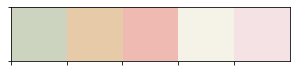

In [3]:
# CPU Libraries
import os
import random
import warnings
import pandas as pd
import numpy as np

import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from fancyimpute import KNN, IterativeImputer, SimpleFill, SoftImpute\
                        ,IterativeSVD, MatrixFactorization\
                        ,NuclearNormMinimization, BiScaler

# GPU Libraries
import cudf
import cupy
from cuml.experimental.preprocessing import MinMaxScaler

seed = 123
random.seed(seed)
np.random.seed(seed)

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

icecream = ["#CCD4BF", "#E7CBA9", "#EEBAB2", "#F5F3E7", "#F5E2E4"]
sns.palplot(sns.color_palette(icecream))

### Custom Functions Below ⬇

In [4]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
    
def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
    color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
        ind = int(val_position * (n_colors - 1)) # target index in the color palette
        return palette[ind]

    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size * size_scale,
        c=color.apply(value_to_color), # Vector of square color values, mapped to color palette
        marker='s'
    )

In [5]:
def inspect_missing_data(df, data_type="Train"):
    '''Insect missing patterns from data to assess next steps.'''
    
    print("--- {} ---".format(data_type))
    
    missing_data = df.isna().sum().reset_index().sort_values(by=0, ascending=False)
    no_missing = missing_data[missing_data[0] != 0].shape[0]
    total_cols = df.shape[1]
    total_rows = df.shape[0]
    
    missing_data.columns = ["name", "missing appearences"]
    missing_data["%missing from total"] = missing_data[missing_data["missing appearences"]!=0]["missing appearences"]/total_rows
    
    too_much_miss = missing_data[missing_data["%missing from total"] > 0.5].shape[0]
    to_drop = missing_data[missing_data["%missing from total"] > 0.5]["name"].to_array()
    
    print("There are {}/{} columns with missing data.".format(no_missing, total_cols))
    print("There are {}/{} columns with more than 50% missing data (these columns will be dropped)".format(too_much_miss,
                                                                                                           no_missing))
    
    return missing_data, to_drop



def distplot_features(data, feature, categorical=False):
    '''Takes a column from the GPU dataframe and plots the distribution (after count).
    data: train + test vector'''
    
    values = []
    for df in data:
        if categorical:
            values.append(cupy.asnumpy(df[feature].value_counts().values))
        else:
            values.append(cupy.asnumpy(df[feature].values))

    print('Mean : train {:,} | test {:,}'.format(np.mean(values[0]), np.mean(values[1])), "\n"
      'Median : train {:,} | test {:,}'.format(np.median(values[0]), np.median(values[1])), "\n"
      'Min: : train {:,} | test {:,}'.format(np.min(values[0]), np.min(values[1])), "\n"
      'Max: : train {:,} | test {:,}'.format(np.max(values[0]), np.max(values[1])))
    
    plt.figure(figsize = (18, 3))
    
    fig = sns.distplot(values[0], hist=False, color = icecream[0], kde_kws = {'lw':4}, label="Train")
    fig = sns.distplot(values[1], hist=False, color = icecream[2], kde_kws = {'lw':4}, label="Test")
    
    plt.title(f'{feature}', fontsize=15)
    plt.legend()
    plt.show();
    
    # Save to W&B
    wandb.log({feature + " Distribution": fig})
    
    
def to_int_cuda(x):
    return cupy.int32(x)

# 2. Import Data 📀

* `TrainingWiDS2021.csv` - train data.
* `UnlabeledWiDS2021.csv` - test data; the variable to predict is `diabetes_mellitus` (on encounters).
* `SolutionTemplateWiDS2021.csv` - a list of all the rows (and encounters) that should be in your submissions.
* `DataDictionaryWiDS2021.csv` - columns descriptors.

> There are 181 columns in total, with 160/181 containing some sort of missing information. Moreover, 74 out of these 160 columns have missing data more than 50% of the cases. Hence, we'll drop these, as attempting to do any sort of imputation might induce a big bias in the data.

In [6]:
# Read in data
train = cudf.read_csv("../input/widsdatathon2021/TrainingWiDS2021.csv")
test = cudf.read_csv("../input/widsdatathon2021/UnlabeledWiDS2021.csv")
data = [train, test]

print("Train : {:,} rows and {:,} columns".format(train.shape[0], train.shape[1]), "\n" + 
      "Test : {:,} rows and {:,} columns".format(test.shape[0], test.shape[1]), "\n")


# ~~~~~~~~~~~~~~~~~~~~~
# Drop unwanted columns
# ~~~~~~~~~~~~~~~~~~~~~
_, to_drop_train = inspect_missing_data(df=train, data_type="Train")
_, to_drop_test = inspect_missing_data(df=test, data_type="Test")
# There is 1 more colum in test but not in train; we'll have to drop that as well in both datasets
diff_test = next(iter(set(to_drop_test) - set(to_drop_train)))
print("! {} has more than 50% missingness in test, but not in train; nevetheless, we'll drop it in both.".format(diff_test))

# Drop columns with more than 50% missingness
train.drop(labels=to_drop_test, axis=1, inplace=True)
test.drop(labels=to_drop_test, axis=1, inplace=True)
# Drop other unnecessary columns
to_drop = ["Unnamed: 0", "hospital_id"]
train.drop(labels=to_drop, axis=1, inplace=True)
test.drop(labels=to_drop, axis=1, inplace=True)

# Save up the encounter_id and diabetes_mellitus (these are needed intact and will be appended later)
encounter_id_train = train["encounter_id"]
encounter_id_test = test["encounter_id"]
diabetes_mellitus_train = train["diabetes_mellitus"]

diabetes_mellitus_train = cudf.DataFrame(diabetes_mellitus_train, 
                                         columns=["diabetes_mellitus"])
diabetes_mellitus_train.to_parquet("target_train.parquet")

train.drop(labels=["encounter_id", "diabetes_mellitus"], axis=1, inplace=True)
test.drop(labels=["encounter_id"], axis=1, inplace=True)

Train : 130,157 rows and 181 columns 
Test : 10,234 rows and 180 columns 

--- Train ---
There are 160/181 columns with missing data.
There are 73/160 columns with more than 50% missing data (these columns will be dropped)
--- Test ---
There are 159/180 columns with missing data.
There are 74/159 columns with more than 50% missing data (these columns will be dropped)
! urineoutput_apache has more than 50% missingness in test, but not in train; nevetheless, we'll drop it in both.


In [7]:
# Let's save the original datasets!
### wel'll save them as artifacts:
### artifacts can be datasets, models and much more!
run = wandb.init(project='wids-datathon-kaggle', name='save-original-data')
artifact = wandb.Artifact(name='original-train-test-data', 
                          type='dataset')

artifact.add_file("../input/widsdatathon2021/TrainingWiDS2021.csv")
artifact.add_file("../input/widsdatathon2021/UnlabeledWiDS2021.csv")
artifact.add_file("../input/wids-datathon-2021-preprocessed-data/target_train.parquet")

wandb.log_artifact(artifact)
wandb.finish()

# 3. Label Encoding

> There are 6 columns that are of type `object`. Hence, before doing any alteration to the dataset, we'll have to encode them (transforming words into encodings/ numbers).

> Difference between LE and OHE:
<img src="https://miro.medium.com/max/2736/0*T5jaa2othYfXZX9W." width=400>

In [8]:
def encoder_train_test(train, test, method="LabelEncoder", prints=True):
    '''Encode object columns in Train and Test, leaving NAs to be imputed later.
    Uses Label Encoder from Sklearn or Dummy Encoding from Pandas.
    Train and Test need to be Pandas dataframes.
    Returns the train and test dataframes with encoded column + a list of 
    the columns what have been encoded.'''
    # Convert to CPU dataframe
    train = train.to_pandas()
    test = test.to_pandas()
    
    # Select all columns with type == "object"
    train_cols = [col for col in train.columns if train[col].dtype == 'object']
    test_cols = [col for col in test.columns if test[col].dtype == 'object']
    string_cols = list(set(train_cols+test_cols))
    if prints:
        print("Train: {} columns to encode.".format(len(train_cols)), "\n"
              "Test: {} columns to encode.".format(len(test_cols)), "\n")
    
        
    # --- Label Encoder ---
    if method == "LabelEncoder":
        
        for df, cols in zip([train, test], [train_cols, test_cols]):
            for col in cols:
                encoder = LabelEncoder()

                ### select all values to encode but NAs (we'll impute these later)
                fit_by = pd.Series([i for i in df[col].unique() 
                                    if type(i) == str])
                encoder.fit(fit_by)
                ### encode the column, leaving NAs untouched
                df[col] = df[col].apply(lambda x: encoder.transform([x])[0] 
                                        if type(x) == str else x)
    
    
    # --- Dummy Encoder ---          
    if method == "Dummy":
    
        # Create Dummy Variables
        encoded_train = pd.get_dummies(train[train_cols])
        encoded_test = pd.get_dummies(test[test_cols])
        
        # Strip columns of leading/trailing spaces
        encoded_train.columns = encoded_train.columns.str.strip()
        encoded_test.columns = encoded_test.columns.str.strip()
        # Erase train or test columns that might be found in the other df
        ### this can and it happens: there are categories in train data 
        ### that aren't found in the test data
        ### nevertheless, they need to be found in both (or not)
        in_train_not_test = list(set(encoded_train.columns) - set(encoded_test.columns))
        in_test_not_train = list(set(encoded_test.columns) - set(encoded_train.columns))       
        
        # Drop old columns and replace with encoded ones
        train.drop(columns=train_cols, axis=1, inplace=True)
        test.drop(columns=test_cols, axis=1, inplace=True)

        train = pd.concat([train, encoded_train], axis=1)
        test = pd.concat([test, encoded_test], axis=1)

        if in_train_not_test:
            train.drop(columns=in_train_not_test, axis=1, inplace=True)

        if in_test_not_train:
            test.drop(columns=in_test_not_train, axis=1, inplace=True)
        
        # Get all categ columns again (updated with latest changes)
        if in_train_not_test:
            new_train_cols = list(set(encoded_train.columns) - set(in_train_not_test))
        else:
            new_train_cols = list(encoded_train.columns)
        if in_test_not_train:
            new_test_cols = list(set(encoded_test.columns) - set(in_test_not_train))
        else:
            new_test_cols = list(encoded_test.columns)
        
        string_cols = list(set(new_train_cols + new_test_cols))
    
    
    # Convert back to GPU dataframe
    train = cudf.DataFrame.from_pandas(train)
    test = cudf.DataFrame.from_pandas(test)
            
    print("Encoding finished.")
    # Categ columns are needed to be properly shifted to int32 later
    return train, test, string_cols

In [9]:
%time
train_le, test_le, string_cols_le = encoder_train_test(train=train, 
                                                       test=test,
                                                       method="LabelEncoder")
# OHE doesn't perform better
# train_ohe, test_ohe, string_cols_ohe = encoder_train_test(train=train, 
#                                                           test=test,
#                                                           method="Dummy")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Train: 6 columns to encode. 
Test: 6 columns to encode. 

Encoding finished.


# 4. Important TRAIN vs TEST differences 🔎

* `encounter_id` - unique on each row (it is used in submission, but NOT during training)
* `hospital_id` - completely different between train and test (columns needs to be dropped)
* `age` - impute NAs; distributions are fairly similar, but with more senior patients in TEST set
* `bmi` & `weight` - fairly similar distributions
* `height` & `age` - little fluctuations

In [10]:
# Initialize new experiment
run = wandb.init(project="wids-datathon-kaggle", name="train-test-diff")

Mean : train 61.99510262125606 | test 62.85362517099863 
Median : train 64.0 | test 65.0 
Min: : train 0.0 | test 18 
Max: : train 89.0 | test 96


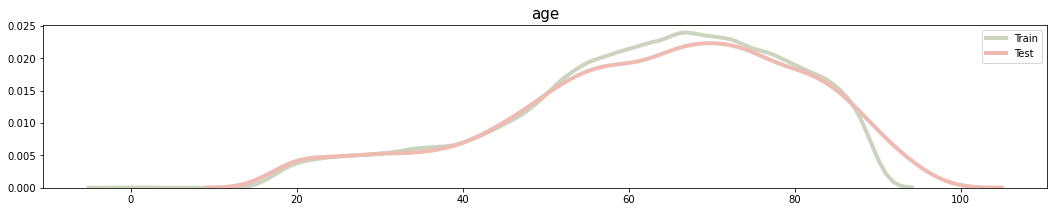

In [11]:
datas = [train[train["age"].isna() == False], test[test["age"].isna() == False]]
distplot_features(data=datas, feature="age", categorical=False)

Mean : train 169.60721892567148 | test 169.27641397362325 
Median : train 170.1 | test 170.0 
Min: : train 137.2 | test 137.0 
Max: : train 195.59 | test 195.6


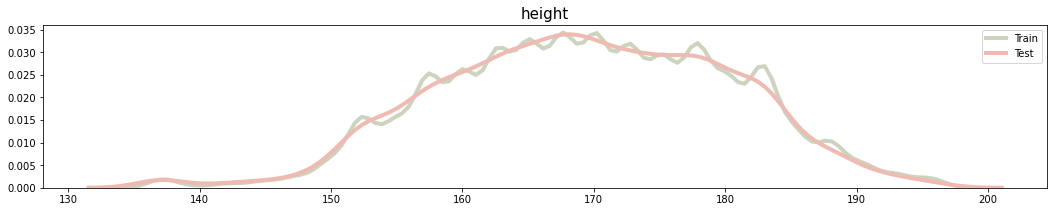

In [12]:
datas = [train[train["height"].isna() == False], test[test["height"].isna() == False]]
distplot_features(data=datas, feature="height", categorical=False)

> We've logged in the plots, so now we can finish this run (or experiment).

In [13]:
# Finish this experiment
wandb.finish()

## Correlation ⚛

> There are many variables that are highly correlated between themselves. Moreover, the number of features in the dataset is quite big itself (~100 feaures). A PCA might be of help in here and might even drive the ROC curve value up.

In [14]:
def correlation_network(data, corr_interval=[-0.8, 0.8], data_type="Train",
                        node_color=icecream[1]):
    '''Returns the correlation Matrix between the variables with highest correlation coefficient.'''
    
    # .corr() in cudf's version doesn't support NAs, so we'll use the Pandas version
    data = data.to_pandas()
    corr = data.corr()
    corr = pd.melt(corr.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']

    # Filter only high correlations
    high_corr = corr[((corr['value'] <= corr_interval[0]) | (corr['value'] >= corr_interval[1]))]
    high_corr = high_corr[(high_corr['value'] != 1)].reset_index(drop=True)
    
    #~~~~~~~~~~~~~~~~~
    #    The Graph
    #~~~~~~~~~~~~~~~~~
    
    sources = list(high_corr.x.unique())
    targets = list(high_corr.y.unique())
    

    plt.figure(figsize=(16, 12))
    # GRAPH OBJECT
    ### easier shorter way to create the nodes & edges object
    g = nx.from_pandas_edgelist(high_corr, source='x', target='y') 

    # Layout
    layout = nx.spring_layout(g, iterations=50, k=0.6, seed=seed)
    # A list of sizes, based on g.degree
    target_size = [g.degree(t) * 80 for t in targets]

    nx.draw_networkx_nodes(g, 
                           layout, 
                           nodelist=targets, 
                           node_size=target_size, 
                           node_color=node_color)
    # Draw every connection
    nx.draw_networkx_nodes(g, layout, nodelist=sources, node_color=node_color, node_size=800, alpha=0.5)

    nx.draw_networkx_edges(g, layout, width=1, edge_color=icecream[1])

    target_dict = dict(zip(targets, targets))
    nx.draw_networkx_labels(g, layout, labels=target_dict)

    plt.axis('off')
    plt.title(f"{data_type}: Highest Correlations Network", fontsize=25)
    plt.show();

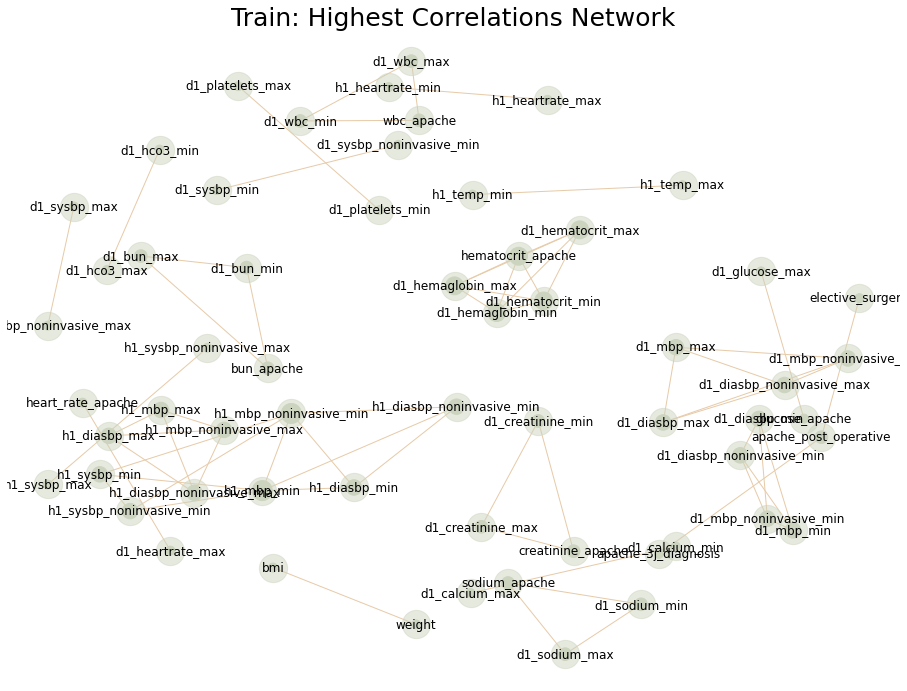

In [15]:
correlation_network(data=train, corr_interval=[-0.8, 0.8], data_type="Train", node_color=icecream[0])

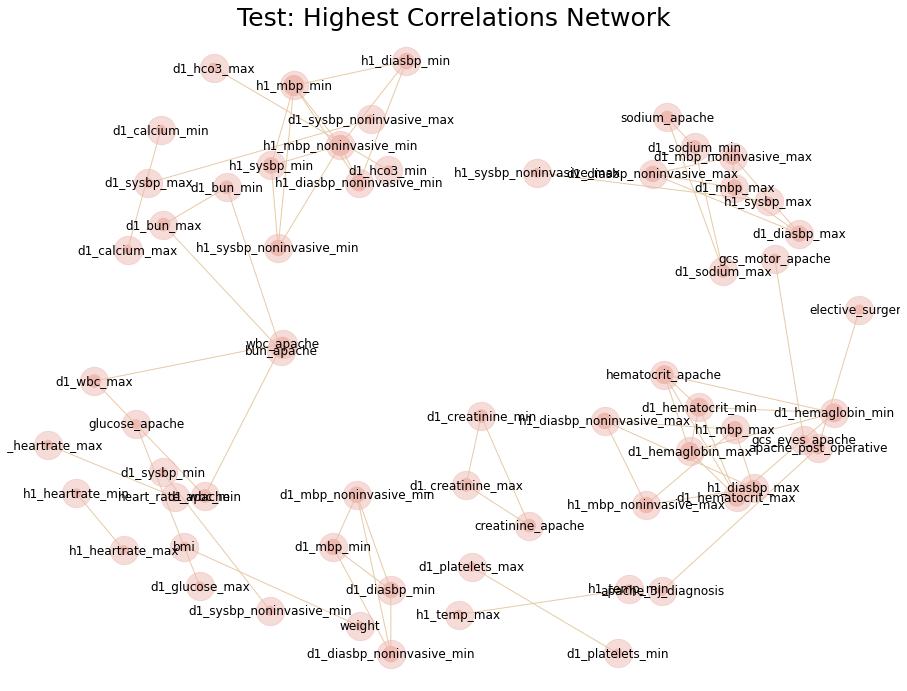

In [16]:
correlation_network(data=test, corr_interval=[-0.8, 0.8], data_type="Test", node_color=icecream[2])

# 5. Imputation 🗄

> `fancyimpute` is a library for missing data imputation algorithms, which uses machine learning algorithms to impute missing values. There are [many algorithms](https://pypi.org/project/fancyimpute/) that can be tried out:
* **KNN**: Nearest neighbor imputations which weights samples using the mean squared difference on features for which two rows both have observed data.
* **IterativeImputer**: A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.
* **SoftImpute**: Matrix completion by iterative soft thresholding of SVD decompositions.
* etc.

In [17]:
def fancy_imputer_train_test(train, test, string_cols, impute_type="mice"):
    '''Imputes the train and test datasets and returns the result.
    string_cols: columns encoded with the label encoder (to be converted as well as int)
    impute_type: could be 'mice' or 'knn' '''
    # Convert to CPU dataframe
    train = train.to_pandas()
    test = test.to_pandas()
    
    print("Imputation has started...")
    if impute_type == "mice":
        mice_imputer = IterativeImputer()
        train_imputed = mice_imputer.fit_transform(train)
        test_imputed = mice_imputer.transform(test)
        
        print("Data Cleanup has started...")
        train_finished = adjust_imputed_data(imputed_data=train_imputed, column_names=train.columns,
                                             string_cols=string_cols)
        test_finished = adjust_imputed_data(imputed_data=test_imputed, column_names=test.columns,
                                             string_cols=string_cols)
        
    
    elif impute_type == "soft":
        imputer = SoftImpute()
        train_imputed = imputer.fit_transform(train)
        test_imputed = imputer.fit_transform(test)
        
        print("Data Cleanup has started...")
        train_finished = adjust_imputed_data(imputed_data=train_imputed, column_names=train.columns,
                                             string_cols=string_cols)
        test_finished = adjust_imputed_data(imputed_data=test_imputed, column_names=test.columns,
                                             string_cols=string_cols)
        
    elif impute_type == "svd":
        imputer = IterativeSVD(verbose=False)
        train_imputed = imputer.fit_transform(train)
        test_imputed = imputer.fit_transform(test)
        
        print("Data Cleanup has started...")
        train_finished = adjust_imputed_data(imputed_data=train_imputed, column_names=train.columns,
                                             string_cols=string_cols)
        test_finished = adjust_imputed_data(imputed_data=test_imputed, column_names=test.columns,
                                             string_cols=string_cols)
     
    # No GPU conversion needed, as they are already GPU dataframes from adjust_imputed_data() function
    print("Imputation has finished.")
    return train_finished, test_finished



def adjust_imputed_data(imputed_data, column_names, string_cols):
    '''Adjusts the output of the imputed data.
    The input is a CPU df and the output is a GPU df.
    Also transforms all initial categorical columns to int64.'''
    data = cudf.DataFrame(imputed_data)
    data.columns = column_names

#     # Transform to int all columns that were int/string in the beginning
#     int64_cols = [col for col in data.columns if data[col].dtype == "int64"]
#     int64_cols.extend(string_cols)
#     for col in int64_cols:
#         data[col] = data[col].applymap(to_int_cuda)
        
    return data

In [18]:
# For the purpose of this notebook running faster, I'll use only
# a fraction of the total data
# to preprocess all, set n = len(train_le) OR n = len(test_le)

train_le_sample = train_le.sample(n=100)
test_le_sample = test_le.sample(n=100)

%time
train_le_mice, test_le_mice = fancy_imputer_train_test(train=train_le_sample, 
                                                       test=test_le_sample,
                                                       string_cols=string_cols_le,
                                                       impute_type="mice")

# You can try using OHE instead of LE and other imputation methods ;)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Imputation has started...
Data Cleanup has started...
Imputation has finished.


> You can see the saved artifacts [here](https://wandb.ai/andrada/wids-datathon-kaggle/artifacts).

In [19]:
# Save to W&B as artifacts
run = wandb.init(project='wids-datathon-kaggle', name='le+mice_process')
artifact = wandb.Artifact(name='preprocessed', 
                          type='dataset')

artifact.add_file("../input/wids-datathon-2021-preprocessed-data/train_le_mice.parquet")
artifact.add_file("../input/wids-datathon-2021-preprocessed-data/test_le_mice.parquet")

wandb.log_artifact(artifact)
wandb.finish()

# Scaling


In [20]:
def scale_data(train, test):
    '''Scales the data using MinMaxScaler from the cuml library.
    Returns the 2 scaled train & test dataframes.'''

    scaler = MinMaxScaler()

    new_train = scaler.fit_transform(train)
    new_test = scaler.transform(test)

    new_train.columns = train.columns
    new_test.columns = test.columns
    
    print("Scaling has finished.")
    return new_train, new_test

In [21]:
train_le_mice_scaled, test_le_mice_scaled = scale_data(train=train_le_mice, 
                                                       test=test_le_mice)

Scaling has finished.


# 6. Save data 📀

> The last step in the preprocessing part is to save the newly processed data. We'll save the data as `.parquet`, as it reads 6 times faster than a `.csv` would.

> You can see the saved artifacts [here](https://wandb.ai/andrada/wids-datathon-kaggle/artifacts).

In [22]:
# Add encounter_id and diabetes_mellitus back to the dataframes
train_le_mice_scaled["encounter_id"] = encounter_id_train
test_le_mice_scaled["encounter_id"] = encounter_id_test

train_le_mice_scaled["diabetes_mellitus"] = diabetes_mellitus_train

# Save data to .parquet (6x faster than .csv)
train_le_mice_scaled.to_parquet('train_le_mice_scaled.parquet')
test_le_mice_scaled.to_parquet('test_le_mice_scaled.parquet')

# Save to W&B as artifacts
run = wandb.init(project='wids-datathon-kaggle', name='le+mice_scale_process')
artifact = wandb.Artifact(name='preprocessed', 
                          type='dataset')

artifact.add_file("../input/wids-datathon-2021-preprocessed-data/train_le_mice_scaled.parquet")
artifact.add_file("../input/wids-datathon-2021-preprocessed-data/test_le_mice_scaled.parquet")

wandb.log_artifact(artifact)
wandb.finish()

# Model Training

In [23]:
# GPU Libraries
import cuml
from cuml.metrics import roc_auc_score
from cuml.preprocessing.model_selection import train_test_split
import xgboost
# Important
from wandb.xgboost import wandb_callback

import pickle

### Data Import ⇢

In [24]:
# Import the data
train = cudf.read_parquet("../input/wids-datathon-2021-preprocessed-data/train_le_mice.parquet")
test = cudf.read_parquet("../input/wids-datathon-2021-preprocessed-data/test_le_mice.parquet")
target_column = cudf.read_parquet("../input/wids-datathon-2021-preprocessed-data/target_train.parquet")

### Functions 🗂

In [25]:
def make_submission(predictions, file_name):
    '''Creates a .csv submission file.'''

    # Create submission
    sample_submission = cudf.read_csv("../input/widsdatathon2021/UnlabeledWiDS2021.csv")
    IDs = sample_submission["encounter_id"]

    to_submit = {'encounter_id': IDs, 'diabetes_mellitus': predictions}
    df_to_submit = cudf.DataFrame(to_submit).set_index(['encounter_id'])
    
    df_to_submit.to_csv(f"{file_name}.csv")
    print("Submission ready.")

# 2. XGBoost ⏳

In [26]:
def train_xgb_model(X_train, X_test, y_train, y_test, params, 
                    details="default", prints=True, step=1):
    
    '''Trains an XGB and returns the trained model + ROC value.'''
    run = wandb.init(project='wids-datathon-kaggle', name=f'xgboost_run_{step}',
                     config=params)
    wandb.log(params)
    
    # Create DMatrix - is optimized for both memory efficiency and training speed.
    train_matrix = xgboost.DMatrix(data = X_train, label = y_train)
    
    # Create & Train the model
    model = xgboost.train(params, dtrain = train_matrix,
                          callbacks=[wandb_callback()],
                         )

    # Make prediction
    predicts = model.predict(xgboost.DMatrix(X_test))
    roc = roc_auc_score(y_test.astype('int32'), predicts)
    wandb.log({'roc':roc})

    if prints:
        print(details + " - ROC: {:.5}".format(roc))
    
    wandb.finish()
    return model, roc


def train_xgb_entire_data(X, y, params):
    '''Use this when you are ready to submit.
    Hence, you can train your tuned model 1 more time, but on the entire available labeled data.
    Returns the trained model.'''
    run = wandb.init(project='wids-datathon-kaggle', name='xgboost_run_entire_data',
                     config=params)
    wandb.log(params)
    
    # Create DMatrix - is optimized for both memory efficiency and training speed.
    train_matrix = xgboost.DMatrix(data = X, label = y)
    
    # Create & Train the model
    model = xgboost.train(params, dtrain = train_matrix,
                          callbacks=[wandb_callback()],
                         )
    
    return model, run

In [27]:
# Establish X and y
y = target_column
X = train

# Simple split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=False, stratify=y)

### XGBoost Models

In [28]:
params1 = {
    'max_depth' : 4,
    'max_leaves' : 2**4,
    'tree_method' : 'gpu_hist',
    'objective' : 'reg:logistic',
    'grow_policy' : 'lossguide',
    'colsample_bynode': 0.8,
}

model1, roc1 = train_xgb_model(X_train, X_test, y_train, y_test, 
                               params1, details="Baseline Model", step=1)

Baseline Model - ROC: 0.81498


In [29]:
# ~~~~~~~~~
#   TUNED
# ~~~~~~~~~

params_final = {
    'max_depth' : 6,
    'max_leaves' : 14,
    'tree_method' : 'gpu_hist',
    'objective' : 'reg:logistic',
    'grow_policy' : 'lossguide',
    'eta' : 0.6,
}

_, _ = train_xgb_model(X_train, X_test, y_train, y_test, 
                               params_final, details="Final Model", step=2)

# Train on the entire dataset
xgb_final_model, run = train_xgb_entire_data(X, y, params=params_final)

Final Model - ROC: 0.82522


In [30]:
# Save final model
pickle.dump(xgb_final_model, open("xgb_le_mice.pickle.dat", "wb"))

In [31]:
# # Save Artifact
# run = wandb.init(project='wids-datathon-kaggle', name='save_xgb_model')
# artifact = wandb.Artifact(name='XGBoost-models', 
#                           type='model')
# artifact.add_dir("./xgb_le_mice.pickle.dat")
# run.log_artifact(artifact)
# wandb.finish()

### XGBoost Submission 📤

In [32]:
# Predict
xgb_final_preds = xgb_final_model.predict(xgboost.DMatrix(test))

make_submission(predictions=xgb_final_preds, file_name="xgb_le_mice")

Submission ready.


### Feature Importance 📊

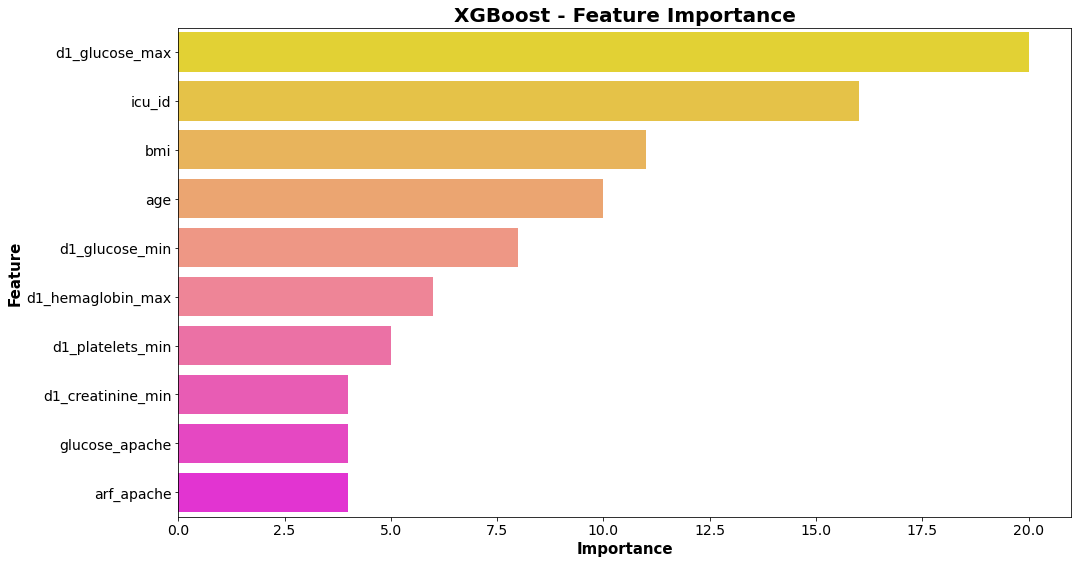

In [33]:
feature_imp = pd.DataFrame(xgb_final_model.get_fscore().items(), 
                           columns=['feature','importance']).\
                            sort_values('importance', ascending=False)
feature_imp = feature_imp.reset_index(drop=True).head(10)

plt.figure(figsize=(16, 9))
ax = sns.barplot(data=feature_imp, x='importance', y='feature',
                 palette="spring_r")
ax.tick_params(axis='both', which='both', labelsize=14)
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel('Importance',fontsize=15, weight="bold")
ax.set_ylabel('Feature',fontsize=15,weight="bold")
plt.title("XGBoost - Feature Importance", size=20, weight="bold")
plt.show();

# 3. Light GBM ⏳

In [34]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
import lightgbm as lgbm
from wandb.lightgbm import wandb_callback

In [35]:
# Variables
features = train.columns.tolist()
target = "diabetes_mellitus"

train["diabetes_mellitus"] = target_column

# Train & Test
train_lgbm, test_lgbm = train_test_split(train, test_size=0.05, shuffle=False)

train_lgbm = train_lgbm.to_pandas()
test_lgbm = test_lgbm.to_pandas()

### Light GBM Training Function

In [36]:
def training_lgbm(train_lgbm, test_lgbm, features, target, param,
                  n_splits=5, stop_round=100, num_rounds=1000, verbose=False, 
                  tuned="None", val=None, return_model=False, step=1):
    
    '''Trains LGBM model.'''
    run = wandb.init(project='wids-datathon-kaggle', name=f'lgbm_run_{step}',
                     config=param)
    wandb.log(param)

    # ~~~~~~~
    #  KFOLD
    # ~~~~~~~
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    oof = np.zeros(len(train_lgbm))
    predictions = np.zeros(len(test_lgbm))

    # Convert Train to Train & Validation
    skf_split = skf.split(X=train_lgbm[features], y=train_lgbm[target].values)
    
    # ~~~~~~~
    #  TRAIN
    # ~~~~~~~
    counter = 1

    for train_index, valid_index in skf_split:
        print("==== Fold {} ====".format(counter))

        lgbm_train = lgbm.Dataset(data = train_lgbm.iloc[train_index, :][features].values,
                                  label = train_lgbm.iloc[train_index, :][target].values,
                                  feature_name = features,
                                  free_raw_data = False)

        lgbm_valid = lgbm.Dataset(data = train_lgbm.iloc[valid_index, :][features].values,
                                  label = train_lgbm.iloc[valid_index, :][target].values,
                                  feature_name = features,
                                  free_raw_data = False)

        lgbm_1 = lgbm.train(params = param, train_set = lgbm_train, valid_sets = [lgbm_valid],
                            early_stopping_rounds = stop_round, num_boost_round=num_rounds, 
                            verbose_eval=verbose, callbacks=[wandb_callback()])


        # X_valid to predict
        oof[valid_index] = lgbm_1.predict(train_lgbm.iloc[valid_index][features].values, 
                                          num_iteration = lgbm_1.best_iteration)
        predictions += lgbm_1.predict(test_lgbm[features], 
                                      num_iteration = lgbm_1.best_iteration) / n_splits

        counter += 1
        
        
    # ~~~~~~~~~~~
    #   OOF EVAL
    # ~~~~~~~~~~~
    print("============================================")
    print("Splits: {} | Stop Round: {} | No. Rounds: {} | {}: {}".format(n_splits, stop_round, 
                                                                            num_rounds, tuned, val))
    print("CV ROC: {:<0.5f}".format(metrics.roc_auc_score(test_lgbm[target], predictions)))
    print("\n")
    wandb.log({'oof_roc': metrics.roc_auc_score(test_lgbm[target], predictions)})
    wandb.finish()
    
    if return_model:
        return lgbm_1

## Model (After Tuning)

> I've done my tunning on my personal Z8 Desktop and here are the results after that:

In [37]:
final_params = {'learning_rate': 0.1,
               'objective': 'binary',
               'metric': 'auc',
               'boosting_type': 'gbdt',
               'max_depth': 6,

               'subsample': 0.2,
               'colsample_bytree': 0.3,
               'reg_alpha': 0.54,
               'reg_lambda': 0.4,
               'min_split_gain': 0.7,
               'min_child_weight': 26,
               'nthread':-1,

               'save_binary': True,
               'seed': 1337, 'feature_fraction_seed': 1337,
               'bagging_seed': 1337, 'drop_seed': 1337, 
               'data_random_seed': 1337,
               'verbose': -1, 
               'is_unbalance': True,
}

training_lgbm(train_lgbm, test_lgbm, features, target, param=final_params,
              n_splits=5, stop_round=100, num_rounds=1000, verbose=200,
              step=1)

==== Fold 1 ====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.863361
[400]	valid_0's auc: 0.865105
Early stopping, best iteration is:
[394]	valid_0's auc: 0.865247
==== Fold 2 ====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.860391
[400]	valid_0's auc: 0.862274
Early stopping, best iteration is:
[400]	valid_0's auc: 0.862274
==== Fold 3 ====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.86576
[400]	valid_0's auc: 0.867228
Early stopping, best iteration is:
[410]	valid_0's auc: 0.867272
==== Fold 4 ====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.864363
Early stopping, best iteration is:
[291]	valid_0's auc: 0.865407
==== Fold 5 ====
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.861778
[400]	valid_0's auc: 0.862373
Early stopping, best iteration is:
[313]	valid_0's auc: 0.862858
Splits: 5 |

### Light GBM Final Model & Submission 📤

In [38]:
# Train on more data
train_lgbm, test_lgbm = train_test_split(train, test_size=0.05, shuffle=False)

train_lgbm = train_lgbm.to_pandas()
test_lgbm = test_lgbm.to_pandas()

final_lgbm = training_lgbm(train_lgbm, test_lgbm, features, target, 
                           param=final_params, n_splits=5, stop_round=100, 
                           num_rounds=1000, verbose=400, return_model=True, step=2)

==== Fold 1 ====
Training until validation scores don't improve for 100 rounds
[400]	valid_0's auc: 0.865053
Early stopping, best iteration is:
[401]	valid_0's auc: 0.865117
==== Fold 2 ====
Training until validation scores don't improve for 100 rounds
[400]	valid_0's auc: 0.862493
Early stopping, best iteration is:
[367]	valid_0's auc: 0.862695
==== Fold 3 ====
Training until validation scores don't improve for 100 rounds
[400]	valid_0's auc: 0.863192
Early stopping, best iteration is:
[314]	valid_0's auc: 0.863304
==== Fold 4 ====
Training until validation scores don't improve for 100 rounds
[400]	valid_0's auc: 0.868322
Early stopping, best iteration is:
[324]	valid_0's auc: 0.868495
==== Fold 5 ====
Training until validation scores don't improve for 100 rounds
[400]	valid_0's auc: 0.860229
Early stopping, best iteration is:
[312]	valid_0's auc: 0.860477
Splits: 5 | Stop Round: 100 | No. Rounds: 1000 | None: None
CV ROC: 0.86037




In [39]:
pickle.dump(final_lgbm, open("lgbm_le_mice.pickle.dat", "wb"))

# Predict test
lgbm_final_preds = final_lgbm.predict(test.to_pandas(), num_iteration = final_lgbm.best_iteration)

make_submission(lgbm_final_preds, file_name="lgbm_le_mice")

Submission ready.


# 4. SVR ⏳

In [40]:
# GPU Libraries
import cuml
from cuml.metrics import roc_auc_score
from cuml.preprocessing.model_selection import train_test_split

import pickle

from cuml.linear_model import LogisticRegression
from cuml.svm import SVC, SVR
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors
from cuml.linear_model import MBSGDClassifier as cumlMBSGDClassifier
from cuml.naive_bayes import MultinomialNB


# --- Functions ---
def train_model(model, X_train, y_train, X_test, y_test, name="default"):
    model.fit(X_train, y_train)
    predicts = model.predict(X_test)
    
    roc = roc_auc_score(y_test, predicts)
    print("Model: {} | ROC: {}".format(name, roc))
    
    
def train_entire_data(model, X, y):
    model.fit(X, y)
    return model

In [41]:
# Establish X and y
y = target_column
X = train.drop(labels=["diabetes_mellitus"], axis=1)

# Simple split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=False, stratify=y)

In [42]:
# Creating and fitting the model
svr_tuned = SVR(kernel='rbf', gamma='scale', C=1, epsilon=0.3)
train_model(model=svr_tuned, X_train=X_train, 
            y_train=y_train, X_test=X_test, 
            y_test=y_test, name="SVR")

Model: SVR | ROC: 0.8128083944320679


In [43]:
# Train on the entire dataset
svr_final = SVR(kernel='rbf', gamma='scale', C=1, epsilon=0.3)
svr_final = train_entire_data(model=svr_final, X=X, y=y)

# Save final model
pickle.dump(svr_final, open("svr_le_mice.pickle.dat", "wb"))

### Submission 📤

In [44]:
svr_predictions = svr_final.predict(test)
make_submission(predictions=svr_predictions, file_name="svr_le_mice")

Submission ready.


# 4. Blend the models 🔬

In [45]:
blended_preds = 0.1*xgb_final_preds + 0.9*lgbm_final_preds
make_submission(blended_preds, file_name="blend_xgb_lgbm")

Submission ready.


In [46]:
best_blend = pd.read_csv("../input/wids-datathon-2021-preprocessed-data/blend05.csv")
best_blend.to_csv("best_blend.csv", index=False)